<a href="https://colab.research.google.com/github/Petinelli-Inc/curvas_vrf/blob/main/capft_low_temps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Leitura e interpretação dos dados

In [3]:
dados = pd.read_excel("teste.xlsx", index_col=0)

In [4]:
"""
Modelo: RMXYQ16AYL

"""
cap_nom = 45
pot_nom = 10.6
cop_nom = cap_nom/pot_nom

# Manipulação dos dados

In [5]:
df_tc = dados[[col for col in dados.columns if col.startswith("TC")]]
df_pi = dados[[col for col in dados.columns if col.startswith("PI")]]

In [6]:
df_capft = df_tc.copy()

df_capft = round(df_capft/cap_nom,4)

df_capft = df_capft.rename(columns=lambda s: f'IWB {s[-2:]}°C')

In [33]:
df_capft

,IWB 14°C,IWB 16°C,IWB 18°C,IWB 19°C,IWB 20°C,IWB 22°C,IWB 24°C
ODB (°C),,,,,,,
10,0.8978,1.0467,1.1444,1.1867,1.2267,1.2933,1.2956
12,0.8978,1.0356,1.1311,1.1733,1.2111,1.2756,1.2800
14,0.8978,1.0244,1.1178,1.1600,1.1978,1.2422,1.2578
16,0.8978,1.0133,1.1044,1.1444,1.1822,1.2133,1.2422
18,0.8933,1.0000,1.0933,1.1333,1.1667,1.1978,1.2244
20,0.8822,0.9911,1.0778,1.1178,1.1511,1.1800,1.2044
21,0.8778,0.9844,1.0733,1.1111,1.1444,1.1711,1.1978
23,0.8689,0.9711,1.0578,1.0956,1.1289,1.1511,1.1756
25,0.8578,0.9600,1.0422,1.0800,1.1111,1.1311,1.1578


In [7]:
ref = df_capft.iloc[0,:].tolist()
col_names = df_capft.columns.tolist()

#for name in range(len(col_names)):
  #col_names[name] = col_names[name][-2:]

odb_index = df_capft.index.tolist()

inflex = {}
limites = {}
low = []
odb = []
iwb = []

for col in range(len(df_capft.columns)):
  for i in range(len(odb_index)):
    if df_capft.iat[i, col] != ref[col]:
      inflex[col_names[col]] = odb_index[i-1]
      limites[col_names[col]] = df_capft.iat[i-1, col]
      break
    elif df_capft.iat[i, col] == ref[col]:
      low.append(ref[col])
      iwb.append(int(col_names[col][4:6]))
      odb.append(odb_index[i])
      continue


In [8]:
odb2 = []
iwb2 = []
iwbodb = []

odb2.clear()
iwb2.clear()


for n in range(len(odb)):
  odb_2 = odb[n]*odb[n]
  odb2.append(odb_2)
  
  iwb_2 = iwb[n]*iwb[n]
  iwb2.append(iwb_2)

  prod = odb[n]*iwb[n]
  iwbodb.append(prod)


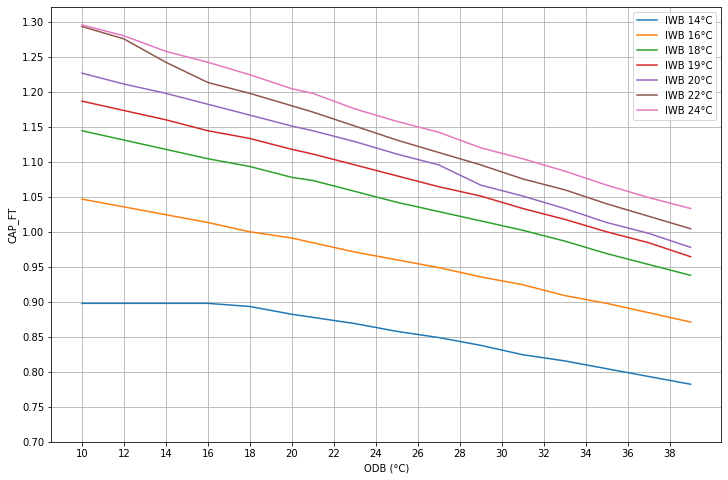

In [9]:
df_capft.plot(yticks = np.arange(0.7,1.3,0.05), xticks = np.arange(10,40,2),
              ylabel = 'CAP_FT', figsize=(12, 8), grid = True)

In [10]:
vet1 = np.ones(10, dtype=int)

x = pd.DataFrame({
    'IWB': iwb,
    'IWB2': iwb2,
    'ODB': odb,
    'ODB2': odb2,
    'IWB*ODB': iwbodb
})

y = pd.DataFrame(low)



In [31]:
x_mat = x.to_numpy()
y_mat = y.to_numpy()
x_t = x_mat.transpose()

prod = np.matmul(x_t, x_mat)

inv = np.linalg.pinv(prod)

coef = np.matmul(np.matmul(inv, x_t), y_mat)

coef = np.concatenate(coef)

coef = coef.tolist()

coef = [round(n,4) for n in coef]


In [12]:
regr = linear_model.LinearRegression()
regr.fit(x, y)

LinearRegression()

In [13]:
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)


Intercept: 
 [-0.05553301]
Coefficients: 
 [[ 1.21532865e-01 -3.70755180e-03 -8.63840549e-02  1.07665394e-04
   5.95188269e-03]]


In [14]:
regr.coef_[0]

array([ 1.21532865e-01, -3.70755180e-03, -8.63840549e-02,  1.07665394e-04,
        5.95188269e-03])

In [15]:
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      0   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     982.7
Date:                Wed, 03 Aug 2022   Prob (F-statistic):           2.01e-07
Time:                        17:32:06   Log-Likelihood:                 37.346
No. Observations:                  10   AIC:                            -64.69
Df Residuals:                       5   BIC:                            -63.18
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.001     -1.026      0.3

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1542: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


In [16]:
x

,const,IWB,IWB2,ODB,ODB2,IWB*ODB
0,1.0,14,196,10,100,140
1,1.0,14,196,12,144,168
2,1.0,14,196,14,196,196
3,1.0,14,196,16,256,224
4,1.0,16,256,10,100,160
5,1.0,18,324,10,100,180
6,1.0,19,361,10,100,190
7,1.0,20,400,10,100,200
8,1.0,22,484,10,100,220
9,1.0,24,576,10,100,240


In [17]:
predictions

0    0.899437
1    0.898058
2    0.897542
3    0.897886
4    1.039087
5    1.149077
6    1.192949
7    1.229406
8    1.280075
9    1.301084
dtype: float64

In [18]:
def biquad(iwb, iwb2, odb, odb2, iwb_odb):
  return -0.0008 + 0.1176*iwb + (-0.0037)*iwb2 + (-0.0919)*odb + 0.0001*odb2 + 0.0063*iwb_odb

def biquad1(iwb, iwb2, odb, odb2, iwb_odb):
  return -0.9197 + 0.1833*iwb + (-0.0037)*iwb2 + (0)*odb + 0.0001*odb2 + (-0.00022)*iwb_odb

def biquad2(iwb, iwb2, odb, odb2, iwb_odb):
  return -0.0555 + 1.21532865e-01*iwb + (-3.70755180e-03)*iwb2 + (-8.63840549e-02)*odb + 1.07665394e-04*odb2 + (5.95188269e-03)*iwb_odb

In [19]:
res = []
res1 = []
res2 = []

for i in x.index: 
  res.append(biquad(x['IWB'][i], x['IWB2'][i], x['ODB'][i], x['ODB2'][i], x['IWB*ODB'][i]))
  res1.append(biquad1(x['IWB'][i], x['IWB2'][i], x['ODB'][i], x['ODB2'][i], x['IWB*ODB'][i]))
  res2.append(biquad2(x['IWB'][i], x['IWB2'][i], x['ODB'][i], x['ODB2'][i], x['IWB*ODB'][i]))

In [20]:
#statsmodel
soma = 0

for i in range(len(res)):
  soma = soma + abs((res[i]-low[i])*100/low[i])
  print(f'{round((res[i]-low[i])*100/low[i], 3)}%')

print(f'{round(soma/len(res),3)} %')

-0.49%
-0.824%
-1.069%
-1.225%
-1.347%
-0.192%
-0.067%
-0.367%
-1.601%
-0.17%
0.735 %


In [21]:
#planilha
soma1 = 0

for i in range(len(res)):
  soma1 = soma1 + abs((res1[i]-low[i])*100/low[i])
  print(f'{round((res1[i]-low[i])*100/low[i], 3)}%')

print(f'{round(soma1/len(res),3)} %')

0.301%
0.105%
-0.002%
-0.02%
-0.573%
0.603%
0.742%
0.457%
-0.742%
0.764%
0.431 %


In [22]:
#sklearn
soma2 = 0

for i in range(len(res)):
  soma2 = soma2 + abs((res2[i]-low[i])*100/low[i])
  print(f'{round((res2[i]-low[i])*100/low[i], 3)}%')

print(f'{round(soma2/len(res),3)} %')

0.186%
0.032%
-0.025%
0.013%
-0.724%
0.412%
0.529%
0.223%
-1.02%
0.426%
0.359 %


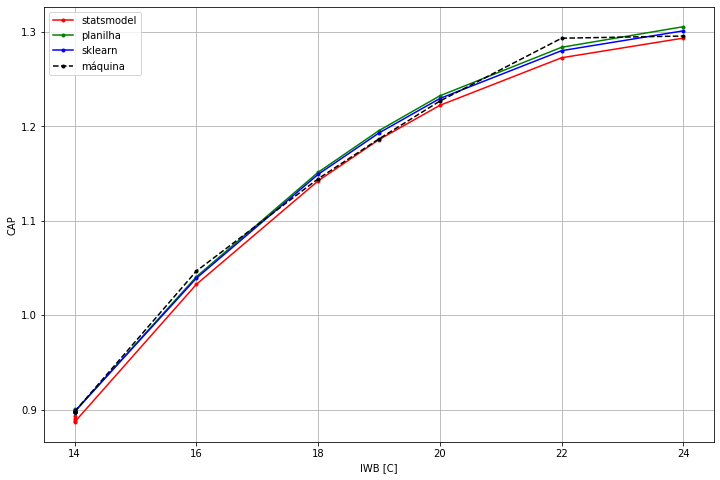

In [23]:
plt.figure(figsize=(12, 8))

plt.plot(iwb, res, label = 'statsmodel', marker = '.', color = 'r', linewidth=1.5)
plt.plot(iwb, res1, marker = '.', label = 'planilha', color = 'g', linewidth=1.5)
plt.plot(iwb, res2, marker = '.', label = 'sklearn', color = 'b', linewidth=1.5)
plt.plot(iwb, low, marker = '.', label = 'máquina', color = 'black', linewidth=1.5, ls = '--')
plt.legend()

plt.xlabel('IWB [C]')
plt.ylabel('CAP')
plt.grid()